####  Assignment_8_&_9 _Gauthami Kuravi


The following questions are to create models for predicting in-hospital mortality for patients 65 years or older at the time of admission.
<ol>
    <li> Model that uses first 24 hours of data and predicts mortality any time (after 24 hours) during hospitalization. </li>
    <li> Model that uses 24-hour sliding window to predict morality at any time during hospitalization. </li>
    <li>Model that predicts mortality within 24 hours at any arbitrary point. </li>
</ol>
For models 2 and 3, create plots that shows how the predicted probability changes over time. This needs to be done for one patient at a time, so pick randomly 10 patients who died and 10 patients who did not die.


In [202]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc
from sklearn.metrics import roc_curve


import random

In [203]:
conn = sqlite3.connect('D:\\mimic.db')

In [217]:
# admissions for patients older than 65
admissions = pd.read_sql('select *, (julianday(date(admittime))-julianday(date(dob)))/365.25 as age from admissions, patients where admissions.subject_id = patients.subject_id and (julianday(date(admittime))-julianday(date(dob)))/365.25 >= 65',conn)

In [204]:
# calculate los in hours
admissions['los_hrs']=admissions.apply(lambda r: (time.mktime(time.strptime(r['DISCHTIME'],'%Y-%m-%d %H:%M:%S')) - 
                 time.mktime(time.strptime(r['ADMITTIME'],'%Y-%m-%d %H:%M:%S')))/3600.0, axis=1)

In [205]:
admissions.columns

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS',
       'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA', 'ROW_ID', 'SUBJECT_ID',
       'GENDER', 'DOB', 'DOD', 'DOD_HOSP', 'DOD_SSN', 'EXPIRE_FLAG', 'age',
       'los_hrs'],
      dtype='object')

In [206]:
admissions[['los_hrs','HADM_ID','SUBJECT_ID']][:10]

,los_hrs,HADM_ID,SUBJECT_ID,SUBJECT_ID
0,330.233333,116935,249,249
1,254.983333,149546,249,249
2,407.950000,158975,249,249
3,115.283333,176189,253,253
4,72.000000,112013,255,255
5,171.733333,155415,256,256
6,157.116667,153771,256,256
7,301.183333,188869,256,256
8,148.083333,108811,256,256
9,68.250000,179006,257,257


In [207]:
# Train and test split
#split admissions by training and testing 
pts = admissions.iloc[:,1].unique()
trp, tsp = train_test_split(pts, train_size=0.8)
tr = admissions[admissions.iloc[:,1].isin(trp)]
ts = admissions[admissions.iloc[:,1].isin(tsp)]

1. Model that uses first 24 hours of data and predicts mortality any time (after 24 hours) during hospitalization.
   I have collected first 24 hours data of 500 patients and trained a model. The AUC obtained is 0.81. However by visualizing all the results deeply I can see that the model trained could only identify 15 patients out 64 patients who are dead. 

In [212]:
dts = []
for i in tr.index[:500]:
  pt = tr.loc[i]  
  print('Patient:', pt.iloc[1])
  for t in range(0, 24, 1):
    #print('Current time: ', t)
    labs = pd.read_sql("select * from labevents where hadm_id = \"" + pt[2] + 
                       "\" and (julianday(CHARTTIME) - julianday(\"" + pt[3] +
                       "\"))*24.0 >= " + str( 0) +
                       " and (julianday(CHARTTIME) - julianday(\"" + pt[3] +
                       "\"))*24.0 < " + str( t ), conn)
    #print('   found labs: ',len(labs.index))
    if len(labs.index) > 0:
        # output
        dead_24 = 0
        flag = 0
        if ((pt['HOSPITAL_EXPIRE_FLAG'] == '1') 
            # check if died in the hospital
            and ((time.strptime(pt['DOD_HOSP'],'%Y-%m-%d %H:%M:%S')).tm_year <= (time.strptime(pt['DISCHTIME'],'%Y-%m-%d %H:%M:%S')).tm_year)
            and ((time.strptime(pt['DOD_HOSP'],'%Y-%m-%d %H:%M:%S')).tm_mon <= (time.strptime(pt['DISCHTIME'],'%Y-%m-%d %H:%M:%S')).tm_mon)
            and ((time.strptime(pt['DOD_HOSP'],'%Y-%m-%d %H:%M:%S')).tm_mday <= (time.strptime(pt['DISCHTIME'],'%Y-%m-%d %H:%M:%S')).tm_mday)
           ):
            flag = 1
            #print('yes')
               
        labs=labs.replace("",np.nan)
        labs['vn'] = labs.apply(lambda r: float(r['VALUENUM']),axis=1)
        gr = labs.groupby('ITEMID')
        #print(pd.DataFrame(gr['vn'].mean()).T)
        d = pd.DataFrame(gr['vn'].mean()).T
        d['class'] = flag
        d['subject_id'] = pt.iloc[1]
        d['hadm_id'] = pt.iloc[2]
        d['t'] = t
        d['dead_24'] = dead_24
        dts.append(d)
print('concatenating data')
dt_train = pd.concat(dts, ignore_index=True) 
del dts


Patient: 249
Patient: 249
Patient: 249
Patient: 255
Patient: 256
Patient: 256
Patient: 256
Patient: 256
Patient: 257
Patient: 266
Patient: 270
Patient: 664
Patient: 667
Patient: 668
Patient: 679
Patient: 679
Patient: 680
Patient: 682
Patient: 688
Patient: 690
Patient: 690
Patient: 690
Patient: 690
Patient: 690
Patient: 690
Patient: 703
Patient: 703
Patient: 704
Patient: 705
Patient: 707
Patient: 708
Patient: 709
Patient: 710
Patient: 711
Patient: 711
Patient: 711
Patient: 711
Patient: 711
Patient: 712
Patient: 716
Patient: 718
Patient: 719
Patient: 726
Patient: 727
Patient: 728
Patient: 728
Patient: 731
Patient: 731
Patient: 732
Patient: 733
Patient: 740
Patient: 743
Patient: 744
Patient: 747
Patient: 747
Patient: 749
Patient: 752
Patient: 754
Patient: 755
Patient: 755
Patient: 756
Patient: 765
Patient: 766
Patient: 767
Patient: 768
Patient: 770
Patient: 774
Patient: 779
Patient: 779
Patient: 781
Patient: 781
Patient: 781
Patient: 782
Patient: 782
Patient: 784
Patient: 785
Patient: 786

C:\Users\skura\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:38: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



KeyboardInterrupt: 

In [209]:
dt_train.head()

,50800,50801,50802,50803,50804,50806,50808,50809,50810,50811,...,51514,51516,51518,51519,51523,class,dead_24,hadm_id,subject_id,t
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,116935,249,330
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,116935,249,329
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,116935,249,328
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,116935,249,327
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,116935,249,326


In [210]:
cls = list(dt_train.columns)

In [211]:
cls.remove('hadm_id')
cls.remove('subject_id')
cls.remove('class')

In [27]:
imp = SimpleImputer()
imp.fit(dt_train)


SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='mean', verbose=0)

In [32]:
st = pd.DataFrame(dt_train.columns)
st['stat'] = imp.statistics_


In [33]:
cols = list(st[st['stat'].notnull()][0])

In [34]:
dt1=pd.DataFrame(imp.transform(dt_train), columns=cols)

In [35]:
lr = LogisticRegression()
lr.fit(dt1[cols],dt1['class'])

C:\Users\skura\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [36]:
probs = lr.predict_proba(dt1[cols])[:,1]

In [37]:
dt1['probs']=probs

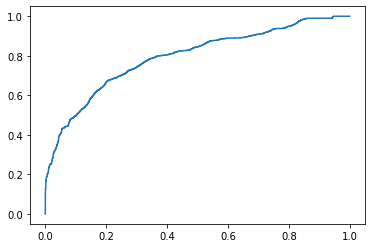

In [38]:
fpr,tpr,thresholds = roc_curve(dt1['class'],probs)
plt.plot(fpr,tpr)

In [39]:
auc(fpr,tpr)

0.7934060669977857

In [40]:
l = list(dt1[dt1['class']==1]['hadm_id'].unique())

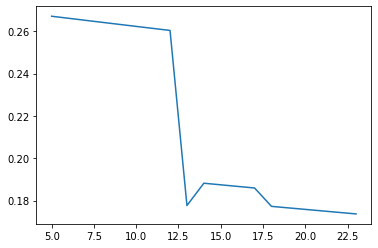

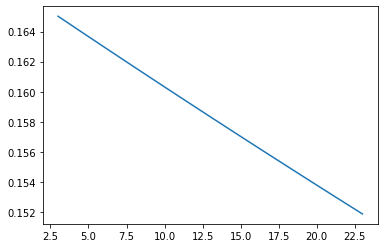

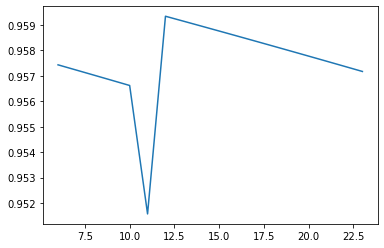

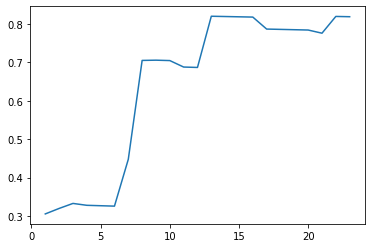

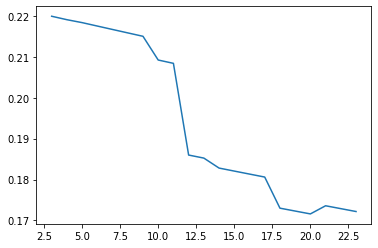

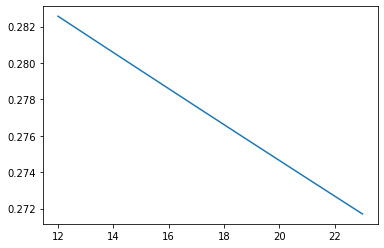

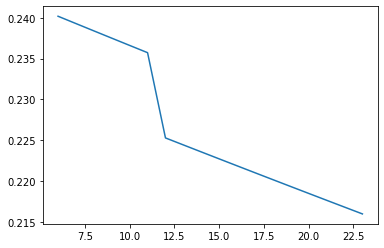

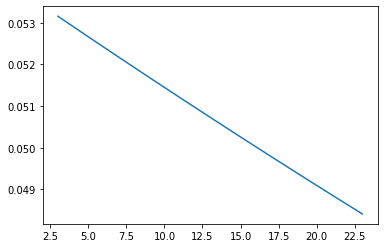

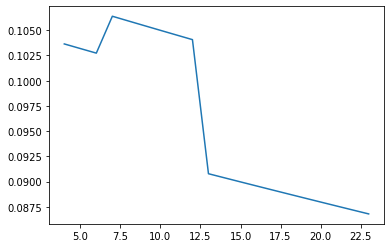

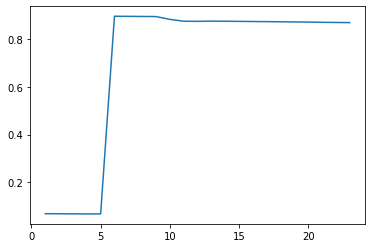

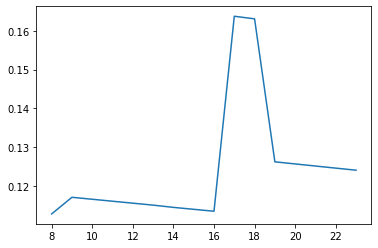

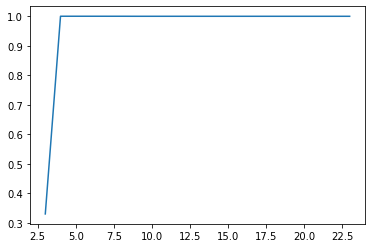

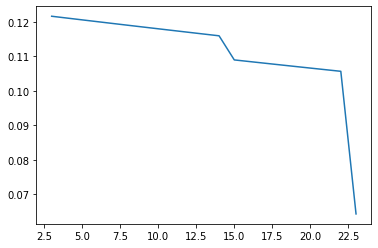

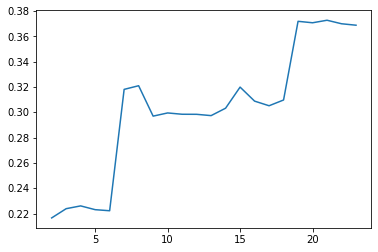

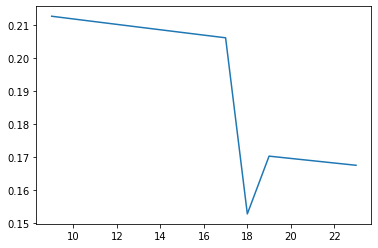

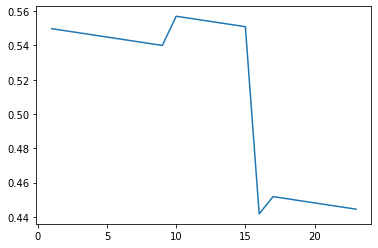

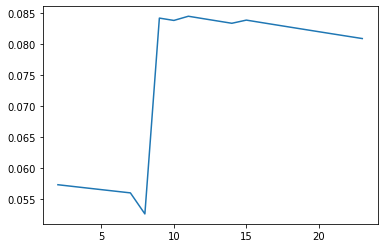

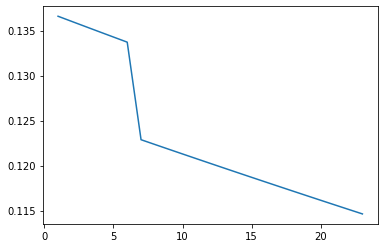

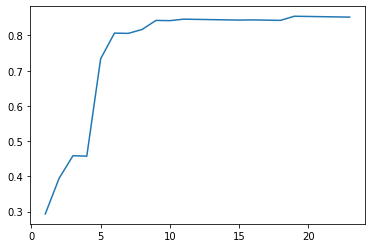

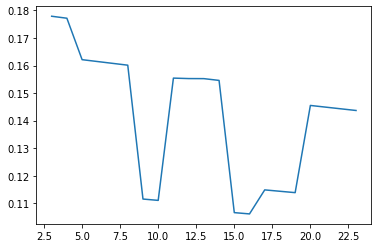

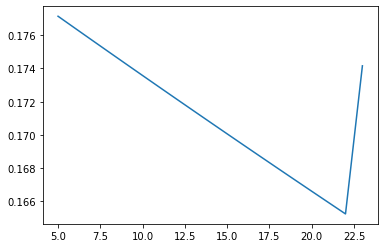

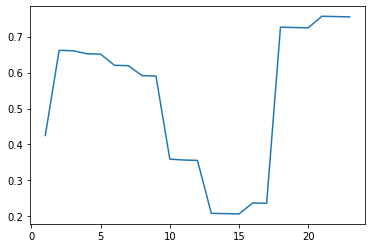

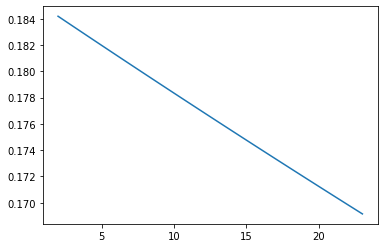

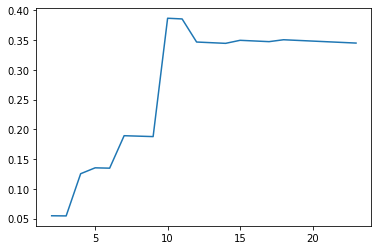

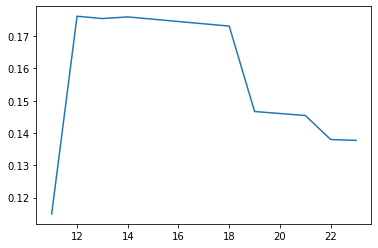

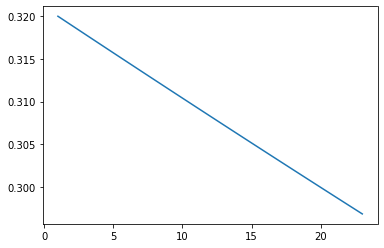

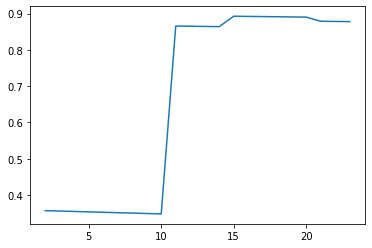

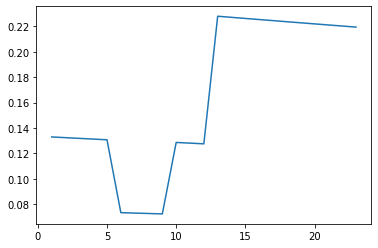

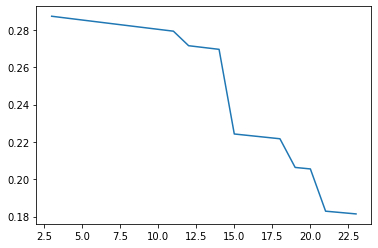

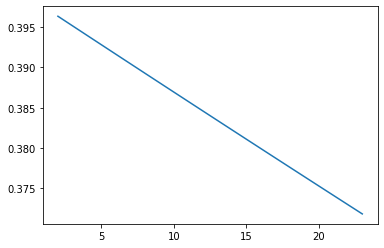

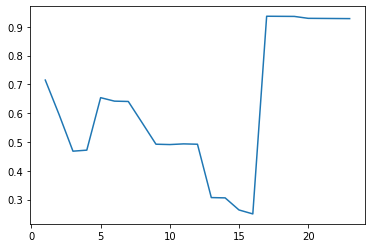

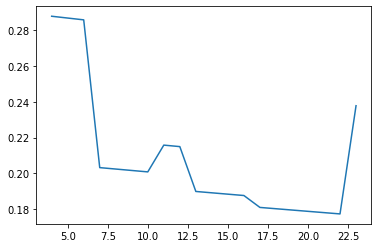

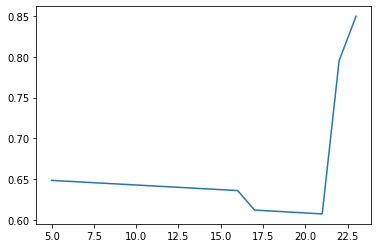

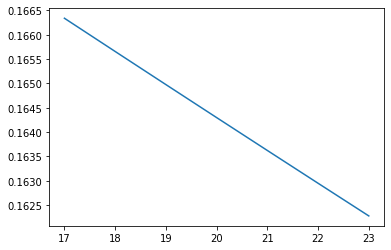

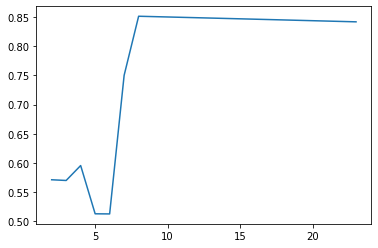

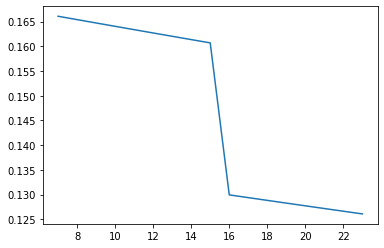

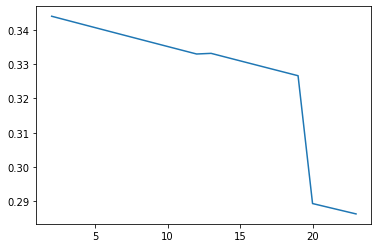

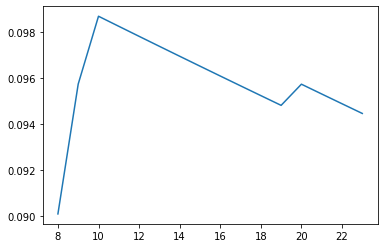

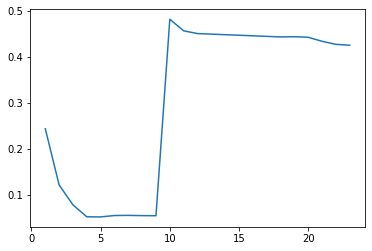

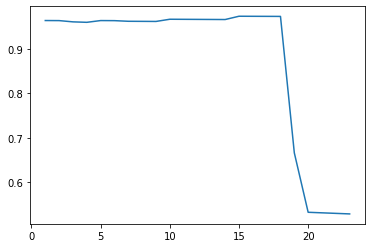

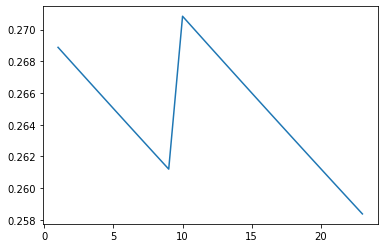

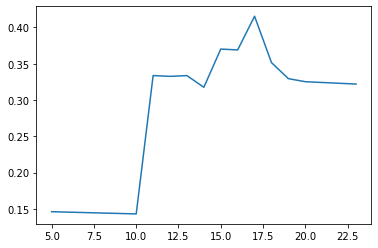

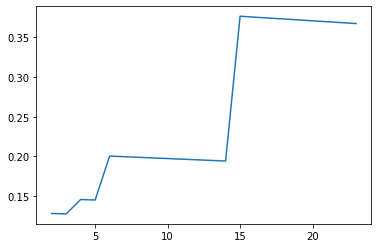

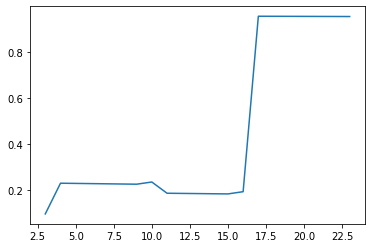

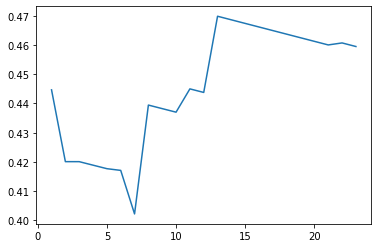

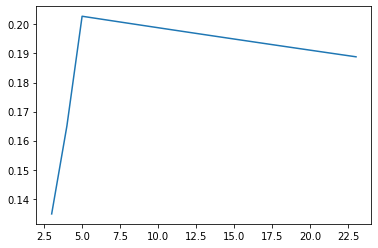

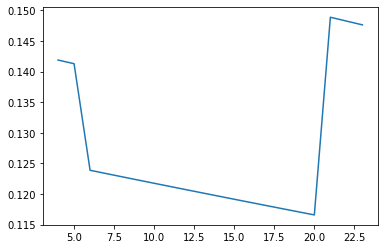

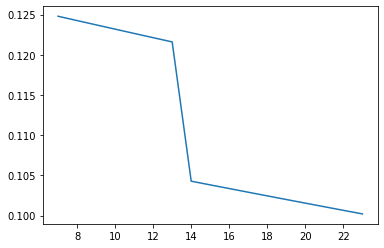

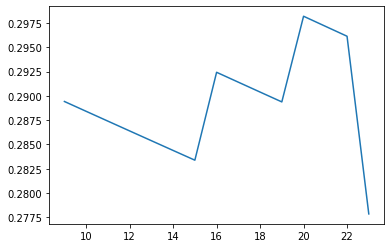

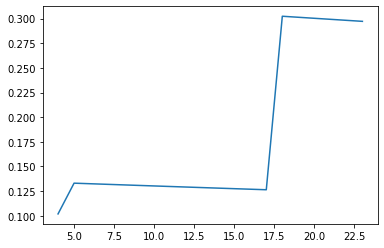

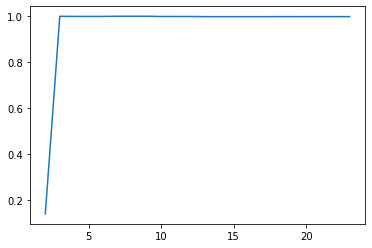

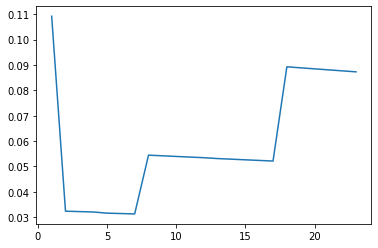

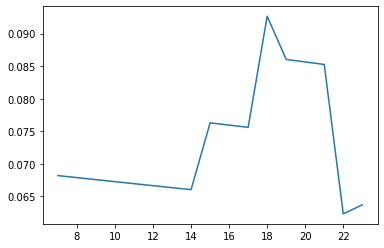

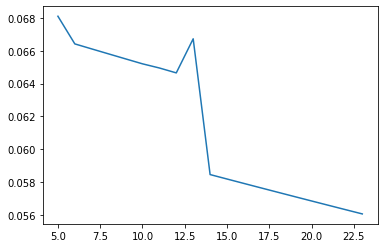

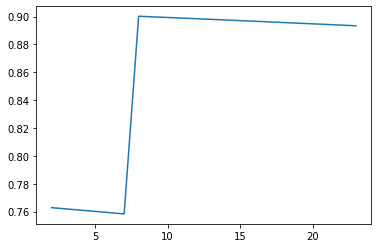

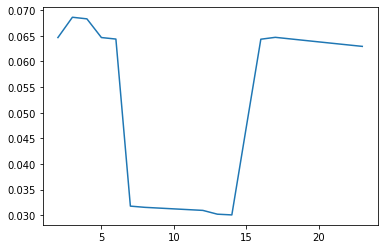

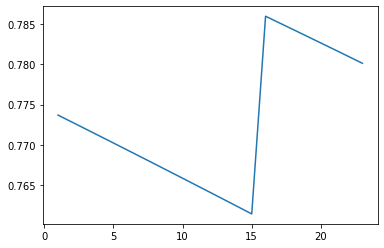

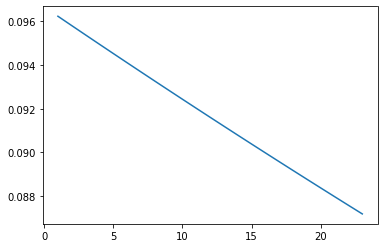

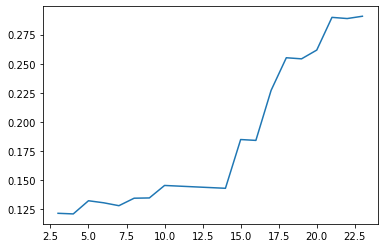

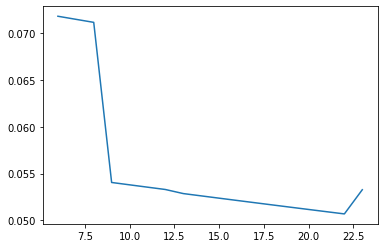

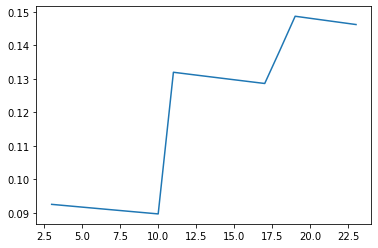

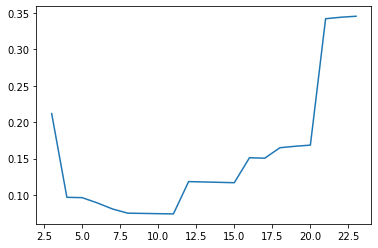

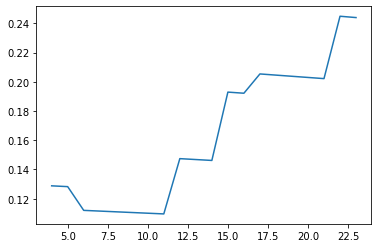

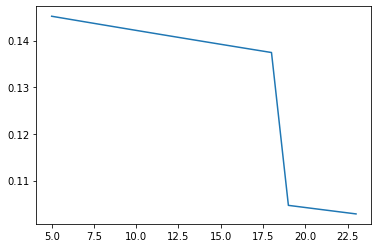

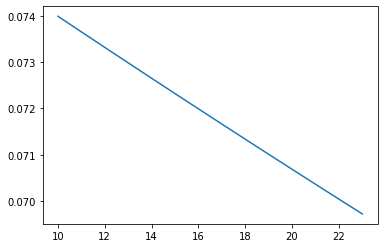

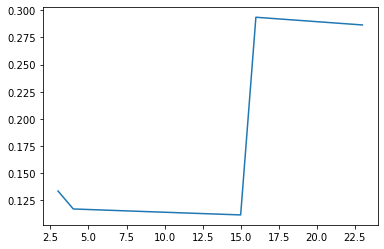

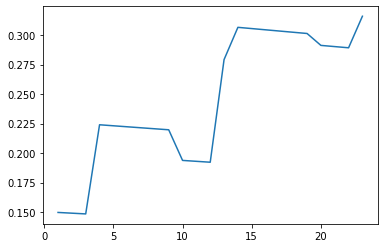

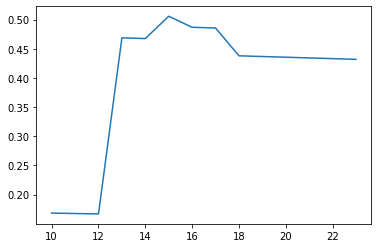

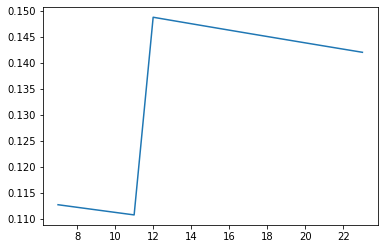

In [41]:
for a in l:
    dt1_sel = dt1[dt1['hadm_id'] == a]
    plt.plot(dt1_sel['t'],dt1_sel['probs'])
    plt.show()


In [42]:
patient_dead_in_hosp = pd.DataFrame()
maxvalue = []
patients = []
flags = []
for patient in l:
    dt1_sel = dt1[dt1['hadm_id']==patient]
    flag = 0
    if dt1_sel['probs'].max() >= 0.5:
        flag = 1
    patients.append(patient)
    maxvalue.append(dt1_sel['probs'].max())
    flags.append(flag)
        

Extracting the patients_id, their probablities of survival and the expiry flag to differentiate between dead and not dead patients

In [43]:
patient_dead_in_hosp['patients'] = patients
patient_dead_in_hosp['high_probs'] = maxvalue
patient_dead_in_hosp['flags'] = flags

In [45]:
patient_dead_in_hosp.head()

,patients,high_probs,flags
0,110404.0,0.267027,0
1,110573.0,0.165016,0
2,113494.0,0.959335,1
3,114242.0,0.819751,1
4,180826.0,0.219948,0


HOSPITAL_EXPIRE_FLAG -1 indicates death in the hospital,  we set a variable flag =1 for dead patients

In [46]:
patient_dead_in_hosp[patient_dead_in_hosp['flags']==1]

,patients,high_probs,flags
2,113494.0,0.959335,1
3,114242.0,0.819751,1
9,144758.0,0.895425,1
11,152051.0,0.999670,1
15,128652.0,0.556999,1
18,175533.0,0.854659,1
21,168006.0,0.756752,1
26,194340.0,0.892537,1
30,134001.0,0.936467,1
32,156909.0,0.849545,1


In [48]:
patient_dead_in_hosp[patient_dead_in_hosp['flags']==1].head

<bound method NDFrame.head of     patients  high_probs  flags
2   113494.0    0.959335      1
3   114242.0    0.819751      1
9   144758.0    0.895425      1
11  152051.0    0.999670      1
15  128652.0    0.556999      1
18  175533.0    0.854659      1
21  168006.0    0.756752      1
26  194340.0    0.892537      1
30  134001.0    0.936467      1
32  156909.0    0.849545      1
34  110233.0    0.851563      1
39  173064.0    0.973507      1
43  138066.0    0.956068      1
50  107822.0    0.998097      1
54  109490.0    0.900251      1
56  108903.0    0.786003      1
67  178159.0    0.505777      1>

In [49]:
patient_dead_in_hosp[patient_dead_in_hosp['flags']==1].shape

(17, 3)

In [26]:
# From the above 2 results we can see that there are 64 patients who dead during their stay in the hospital but from the
#models trained using 24hour data we can only identify 15 patients. That means it is difficult to predict the
# mortality rate of the patient by looking just 24 hours of data.

2. Model that uses 24-hour sliding window to predict morality at any time during hospitalization.

In [53]:
window_forward = 24
window_width = 24
window_back = 24
shift = 1
window_size = 24
dts = []
for i in tr.index[:100]:
  pt = tr.loc[i]  
  print('Patient:', pt.iloc[1])
  for t in range(window_back, int(pt['los_hrs'])-window_forward, shift):
    #print('Current time: ', t)
    labs = pd.read_sql("select * from labevents where hadm_id = \"" + pt[2] + 
                       "\" and (julianday(CHARTTIME) - julianday(\"" + pt[3] +
                       "\"))*24.0 >= " + str( 0) +
                       " and (julianday(CHARTTIME) - julianday(\"" + pt[3] +
                       "\"))*24.0 < " + str( t ), conn)
    #print('   found labs: ',len(labs.index))
    if len(labs.index) > 0:
        # output
        flag = 0
        if ((pt['HOSPITAL_EXPIRE_FLAG'] == '1') 
            # check if died on the day of discharge
            and ((time.strptime(pt['DOD_HOSP'],'%Y-%m-%d %H:%M:%S')).tm_year == (time.strptime(pt['DISCHTIME'],'%Y-%m-%d %H:%M:%S')).tm_year)
            and ((time.strptime(pt['DOD_HOSP'],'%Y-%m-%d %H:%M:%S')).tm_mon == (time.strptime(pt['DISCHTIME'],'%Y-%m-%d %H:%M:%S')).tm_mon)
            and ((time.strptime(pt['DOD_HOSP'],'%Y-%m-%d %H:%M:%S')).tm_mday == (time.strptime(pt['DISCHTIME'],'%Y-%m-%d %H:%M:%S')).tm_mday)
            # check if died on in window
            and (time.mktime(time.strptime(pt['ADMITTIME'],'%Y-%m-%d %H:%M:%S')) + (t + window_width) * 3600 >
                 time.mktime(time.strptime(pt['DOD_HOSP'],'%Y-%m-%d %H:%M:%S')) )
           ):
            flag = 1
            #print('yes')      
        labs=labs.replace("",np.nan)
        labs['vn'] = labs.apply(lambda r: float(r['VALUENUM']),axis=1)
        gr = labs.groupby('ITEMID')
        #print(pd.DataFrame(gr['vn'].mean()).T)
        d = pd.DataFrame(gr['vn'].mean()).T
        d['class'] = flag
        d['subject_id'] = pt.iloc[1]
        d['hadm_id'] = pt.iloc[2]
        d['t'] = t
        dts.append(d)
print('concatenating data')
patients_sliding = pd.concat(dts, ignore_index=True) 
del dts


Patient: 249
Patient: 249
Patient: 249
Patient: 253
Patient: 255
Patient: 257
Patient: 261
Patient: 266
Patient: 268
Patient: 270
Patient: 664
Patient: 665
Patient: 665
Patient: 667
Patient: 668
Patient: 670
Patient: 674
Patient: 674
Patient: 679
Patient: 679
Patient: 680
Patient: 682
Patient: 690
Patient: 690
Patient: 690
Patient: 690
Patient: 690
Patient: 690
Patient: 695
Patient: 695
Patient: 700
Patient: 703
Patient: 703
Patient: 704
Patient: 705
Patient: 707
Patient: 708
Patient: 710
Patient: 711
Patient: 711
Patient: 711
Patient: 711
Patient: 711
Patient: 712
Patient: 716
Patient: 717
Patient: 718
Patient: 719
Patient: 723
Patient: 726
Patient: 731
Patient: 731
Patient: 732
Patient: 733
Patient: 740
Patient: 743
Patient: 744
Patient: 747
Patient: 747
Patient: 749
Patient: 754
Patient: 755
Patient: 755
Patient: 766
Patient: 767
Patient: 768
Patient: 770
Patient: 771
Patient: 771
Patient: 772
Patient: 779
Patient: 779
Patient: 780
Patient: 781
Patient: 781
Patient: 781
Patient: 782

C:\Users\skura\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:43: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [201]:
patients_sliding.head()

,50800,50801,50802,50803,50804,50805,50806,50808,50809,50810,...,51514,51515,51516,51518,51519,51523,class,hadm_id,subject_id,t
0,NaN,NaN,1.5,NaN,33.25,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,116935,249,24
1,NaN,NaN,1.5,NaN,33.25,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,116935,249,25
2,NaN,NaN,1.5,NaN,33.25,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,116935,249,26
3,NaN,NaN,1.6,NaN,33.00,NaN,NaN,NaN,209.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,116935,249,27
4,NaN,NaN,1.6,NaN,33.00,NaN,NaN,NaN,209.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,116935,249,28


In [55]:
cls = list(patients_sliding.columns)

In [56]:
cls.remove('hadm_id')
cls.remove('subject_id')
cls.remove('class')

In [57]:
imp = SimpleImputer()
imp.fit(patients_sliding)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='mean', verbose=0)

In [58]:
st = pd.DataFrame(patients_sliding.columns)
st['stat'] = imp.statistics_


In [59]:
cols = list(st[st['stat'].notnull()][0])

In [60]:
dt1=pd.DataFrame(imp.transform(patients_sliding), columns=cols)

In [75]:
dt1.shape

(24101, 233)

In [61]:
lr = LogisticRegression()
lr.fit(dt1[cols],dt1['class'])

C:\Users\skura\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\skura\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [62]:
probs = lr.predict_proba(dt1[cols])[:,1]

In [63]:
dt1['probs']=probs

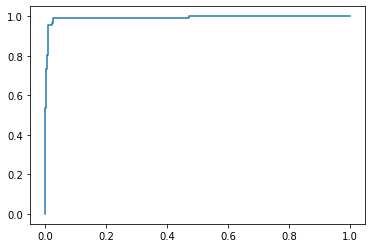

In [64]:
fpr,tpr,thresholds = roc_curve(dt1['class'],probs)
plt.plot(fpr,tpr)

In [65]:
auc(fpr,tpr)

0.9926949405382228

In [102]:
l = list(dt1[dt1['class']==1]['hadm_id'].unique())


In [143]:
l

[110404.0,
 110573.0,
 113494.0,
 114242.0,
 180826.0,
 148109.0,
 133099.0,
 183370.0,
 144758.0,
 138064.0,
 152051.0]

In [144]:
#patient_hadm_ids = dt1.hadm_id.unique()
#patient_hadm_ids 
#unique = dt1['hadm_id'].isin(patient_hadm_ids)
#unique.hadm_id
#lab_e = labevents.loc[lab_events]

#l1 =dt1.loc[unique]
#l1
#filter1

In [68]:
patient_dead_in_hosp = pd.DataFrame()
maxvalue = []
patients = []
flags = []
for patient in l:
    dt1_sel = dt1[dt1['hadm_id']==patient]
    flag = 0
    if dt1_sel['probs'].max() >= 0.5:
        flag = 1
    patients.append(patient)
    maxvalue.append(dt1_sel['probs'].max())
    flags.append(flag)

In [69]:
patient_dead_in_hosp['patients'] = patients
patient_dead_in_hosp['high_probs'] = maxvalue
patient_dead_in_hosp['flags'] = flags

In [72]:
patient_dead_in_hosp

(11, 3)

In [79]:
patient_dead_in_hosp[patient_dead_in_hosp['flags']==1]

,patients,high_probs,flags
3,114242.0,0.844758,1
5,148109.0,0.598768,1
9,138064.0,0.668289,1
10,152051.0,0.939868,1


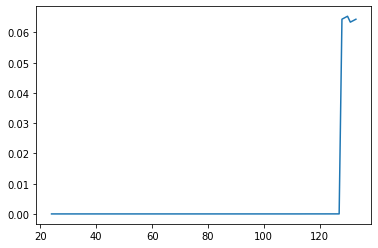

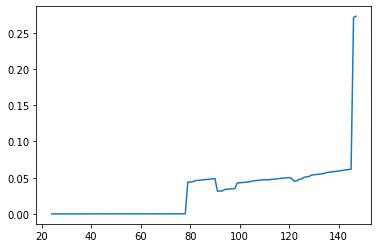

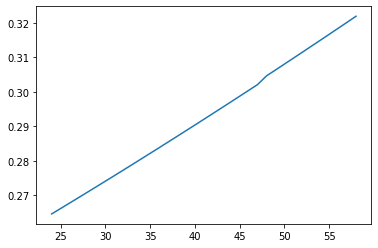

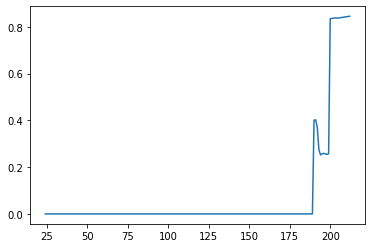

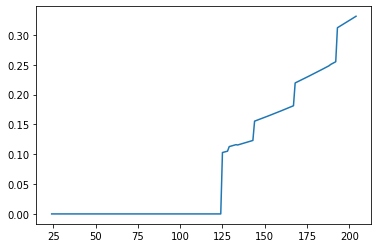

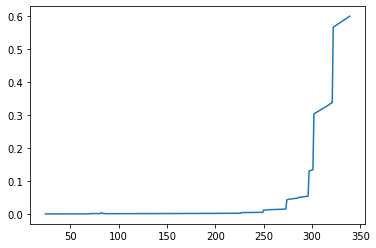

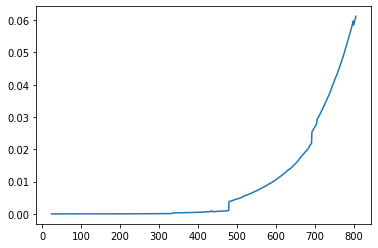

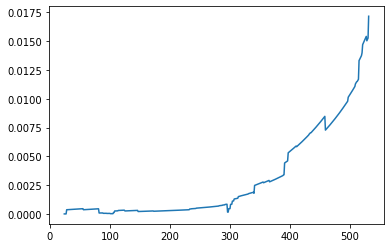

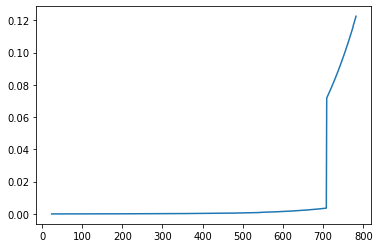

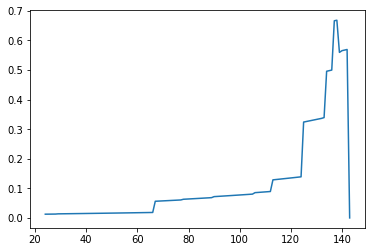

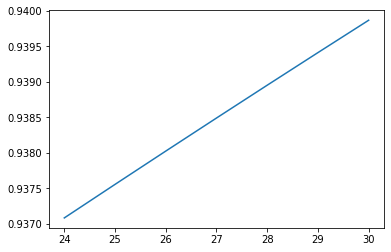

In [80]:
list_hosp = patient_dead_in_hosp['patients']
random = list_hosp.sample(n =10)
for a in random:
    dt1_sel = dt1[dt1['hadm_id'] == a]
    plt.plot(dt1_sel['t'],dt1_sel['probs'])
    plt.show()


In [145]:
l_notdead = list(dt1[dt1['class']==0]['hadm_id'].unique())

In [82]:
patient_notdead_in_hosp = pd.DataFrame()
maxvalue = []
patients = []
flags = []
for patient in l:
    dt1_sel = dt1[dt1['hadm_id']==patient]
    flag = 0
    if dt1_sel['probs'].max() >= 0.5:
        flag = 1
    patients.append(patient)
    maxvalue.append(dt1_sel['probs'].max())
    flags.append(flag)

In [83]:
patient_notdead_in_hosp['patients'] = patients
patient_notdead_in_hosp['high_probs'] = maxvalue
patient_notdead_in_hosp['flags'] = flags

In [87]:
list_hosp = patient_notdead_in_hosp['patients']


(11,)

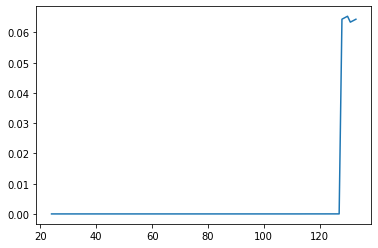

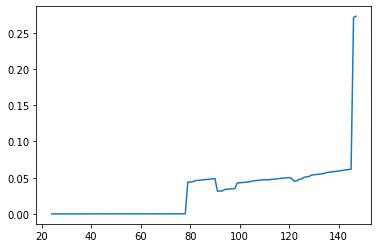

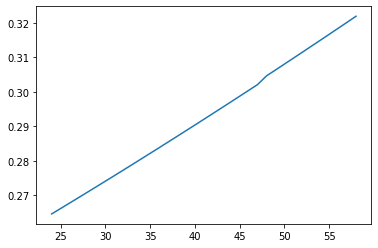

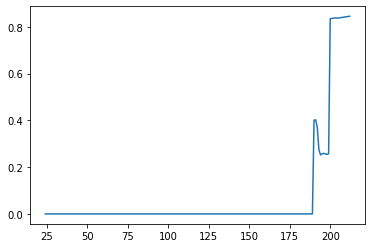

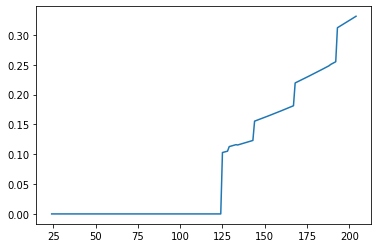

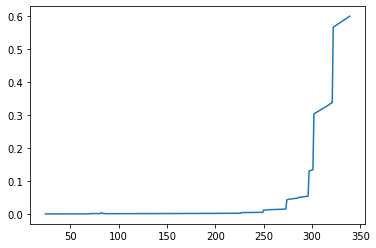

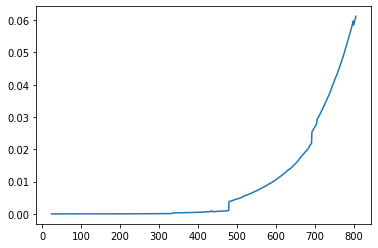

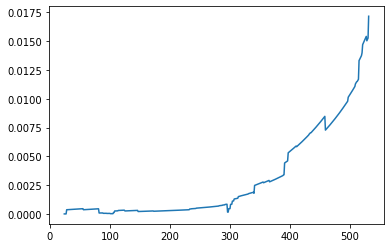

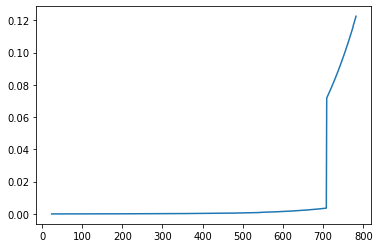

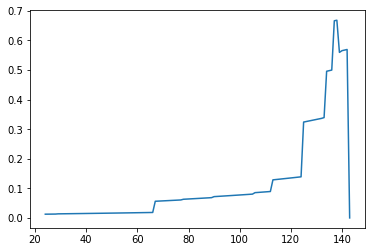

In [88]:
random = list_hosp.sample(n =10)
for a in random:
    dt1_sel = dt1[dt1['hadm_id'] == a]
    plt.plot(dt1_sel['t'],dt1_sel['probs'])
    plt.show()

#####  From the above 2 results we can see that there are total 9 patients died and out of which my model could identify 6 patients.


3. Model that predicts mortality within 24 hours at any arbitrary point.

In [146]:
# I consider an arbitary point of 24hrs before los
dts = []
for i in tr.index[:500]:
  pt = tr.loc[i]  
  print('Patient:', pt.iloc[1])
  pt_los = int(pt.iloc[-1])
  for t in range(pt_los, (pt_los-24), -1):
    #print('Current time: ', t)
    labs = pd.read_sql("select * from labevents where hadm_id = \"" + pt[2] + 
                       "\" and (julianday(CHARTTIME) - julianday(\"" + pt[3] +
                       "\"))*24.0 >= " + str(pt_los - 24 ) +
                       " and (julianday(CHARTTIME) - julianday(\"" + pt[3] +
                       "\"))*24.0 < " + str( pt_los ), conn)
    #print('   found labs: ',len(labs.index))
    if len(labs.index)>0 and t >0:
        # output
        dead_24 = 0
        flag = 0
        if ((pt['HOSPITAL_EXPIRE_FLAG'] == '1') 
            # check if died in the hospital
            and ((time.strptime(pt['DOD_HOSP'],'%Y-%m-%d %H:%M:%S')).tm_year == (time.strptime(pt['DISCHTIME'],'%Y-%m-%d %H:%M:%S')).tm_year)
            and ((time.strptime(pt['DOD_HOSP'],'%Y-%m-%d %H:%M:%S')).tm_mon == (time.strptime(pt['DISCHTIME'],'%Y-%m-%d %H:%M:%S')).tm_mon)
            and ((time.strptime(pt['DOD_HOSP'],'%Y-%m-%d %H:%M:%S')).tm_mday == (time.strptime(pt['DISCHTIME'],'%Y-%m-%d %H:%M:%S')).tm_mday)
            and ((time.mktime(time.strptime(pt['ADMITTIME'],'%Y-%m-%d %H:%M:%S')) + (t) * 3600 >
                 time.mktime(time.strptime(pt['DOD_HOSP'],'%Y-%m-%d %H:%M:%S'))))
           ):
            flag = 1
            #print('yes')
               
        labs=labs.replace("",np.nan)
        labs['vn'] = labs.apply(lambda r: float(r['VALUENUM']),axis=1)
        gr = labs.groupby('ITEMID')
        #print(pd.DataFrame(gr['vn'].mean()).T)
        d = pd.DataFrame(gr['vn'].mean()).T
        d['class'] = flag
        d['subject_id'] = pt.iloc[1]
        d['hadm_id'] = pt.iloc[2]
        d['t'] = t
        d['dead_24'] = dead_24
        dts.append(d)
print('concatenating data')
dt_train = pd.concat(dts, ignore_index=True) 
del dts


Patient: 249
Patient: 249
Patient: 249
Patient: 253
Patient: 255
Patient: 257
Patient: 261
Patient: 266
Patient: 268
Patient: 270
Patient: 664
Patient: 665
Patient: 665
Patient: 667
Patient: 668
Patient: 670
Patient: 674
Patient: 674
Patient: 679
Patient: 679
Patient: 680
Patient: 682
Patient: 690
Patient: 690
Patient: 690
Patient: 690
Patient: 690
Patient: 690
Patient: 695
Patient: 695
Patient: 700
Patient: 703
Patient: 703
Patient: 704
Patient: 705
Patient: 707
Patient: 708
Patient: 710
Patient: 711
Patient: 711
Patient: 711
Patient: 711
Patient: 711
Patient: 712
Patient: 716
Patient: 717
Patient: 718
Patient: 719
Patient: 723
Patient: 726
Patient: 731
Patient: 731
Patient: 732
Patient: 733
Patient: 740
Patient: 743
Patient: 744
Patient: 747
Patient: 747
Patient: 749
Patient: 754
Patient: 755
Patient: 755
Patient: 766
Patient: 767
Patient: 768
Patient: 770
Patient: 771
Patient: 771
Patient: 772
Patient: 779
Patient: 779
Patient: 780
Patient: 781
Patient: 781
Patient: 781
Patient: 782

C:\Users\skura\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [147]:
dt_train.head()

,50800,50801,50802,50803,50804,50806,50808,50809,50810,50811,...,51514,51516,51518,51519,51523,class,dead_24,hadm_id,subject_id,t
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,116935,249,330
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,116935,249,329
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,116935,249,328
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,116935,249,327
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,116935,249,326


In [148]:
cls = list(dt_train.columns)

In [149]:
cls.remove('hadm_id')
cls.remove('subject_id')
cls.remove('class')

In [150]:
imp = SimpleImputer()
imp.fit(dt_train)


SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='mean', verbose=0)

In [151]:
st = pd.DataFrame(dt_train.columns)
st['stat'] = imp.statistics_


In [152]:
cols = list(st[st['stat'].notnull()][0])

In [153]:
dt1=pd.DataFrame(imp.transform(dt_train), columns=cols)

In [154]:
lr = LogisticRegression()
lr.fit(dt1[cols],dt1['class'])

C:\Users\skura\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [155]:
probs = lr.predict_proba(dt1[cols])[:,1]

In [156]:
dt1['probs'] = probs

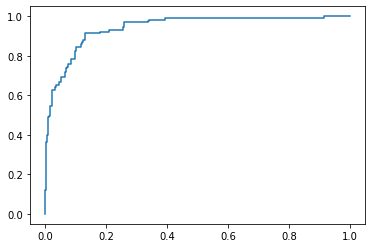

In [157]:
fpr,tpr,thresholds = roc_curve(dt1['class'],probs)
plt.plot(fpr,tpr)

In [158]:
auc(fpr,tpr)

0.9433133911960309

In [193]:
l = list(dt1[dt1['class']==1]['hadm_id'].unique())

In [194]:
patient_dead_in_hosp = pd.DataFrame()
maxvalue = []
patients = []
flags = []
for patient in l:
    dt1_sel = dt1[dt1['hadm_id']==patient]
    flag = 0
    if dt1_sel['probs'].max() >= 0.5:
        flag = 1
    patients.append(patient)
    maxvalue.append(dt1_sel['probs'].max())
    flags.append(flag)
        

In [195]:
patient_dead_in_hosp['patients'] = patients
patient_dead_in_hosp['high_probs'] = maxvalue
patient_dead_in_hosp['flags'] = flags

In [196]:
x = patient_dead_in_hosp[patient_dead_in_hosp['flags']==1]
x.shape

(12, 3)

In [197]:
patient_dead_in_hosp.shape

(41, 3)

In [198]:
patient_dead_in_hosp = pd.DataFrame()
maxvalue = []
patients = []
flags = []
for patient in l:
    dt1_sel = dt1[dt1['hadm_id']==patient]
    flag = 0
    if dt1_sel['probs'].max() >= 0.5:
        flag = 1
    patients.append(patient)
    maxvalue.append(dt1_sel['probs'].max())
    flags.append(flag)

In [199]:
patient_dead_in_hosp['patients'] = patients
patient_dead_in_hosp['high_probs'] = maxvalue
patient_dead_in_hosp['flags'] = flags

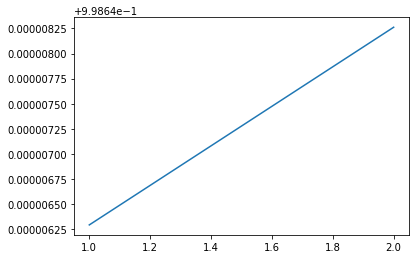

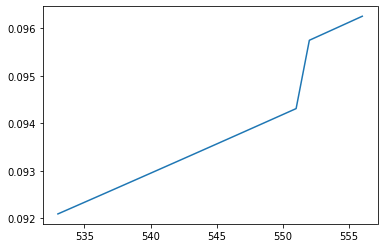

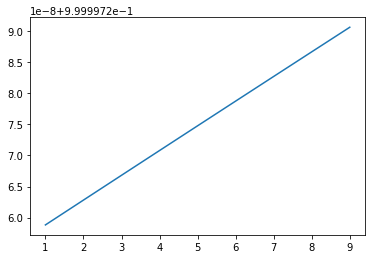

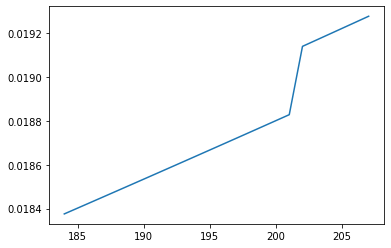

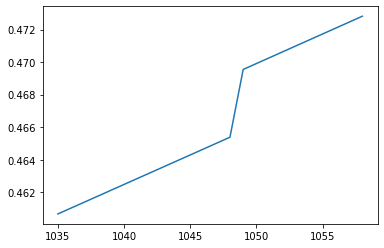

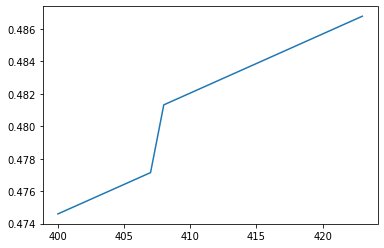

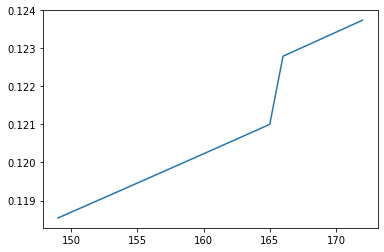

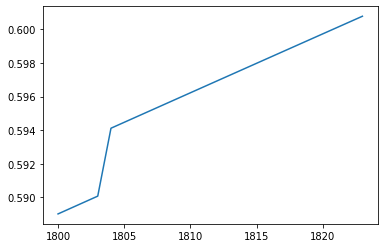

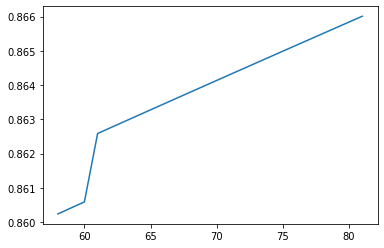

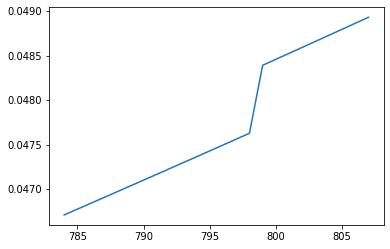

In [200]:
import random
list_hosp = patient_dead_in_hosp['patients']
random = list_hosp.sample(n =10)
for a in random:
    dt1_sel = dt1[dt1['hadm_id'] == a]
    plt.plot(dt1_sel['t'],dt1_sel['probs'])
    plt.show()


In [186]:
l_notdead = list(dt1[dt1['class']==0]['hadm_id'].unique())

In [187]:
patient_notdead_in_hosp = pd.DataFrame()
maxvalue = []
patients = []
flags = []
for patient in l_notdead:
    dt1_sel = dt1[dt1['hadm_id']==patient]
    flag = 0
    if dt1_sel['probs'].max() >= 0.5:
        flag = 1
    patients.append(patient)
    maxvalue.append(dt1_sel['probs'].max())
    flags.append(flag)

In [188]:
patient_notdead_in_hosp['patients'] = patients
patient_notdead_in_hosp['high_probs'] = maxvalue
patient_notdead_in_hosp['flags'] = flags

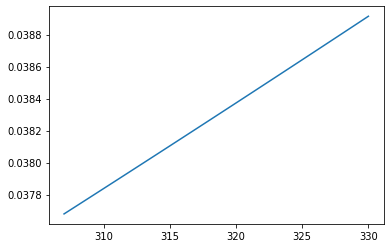

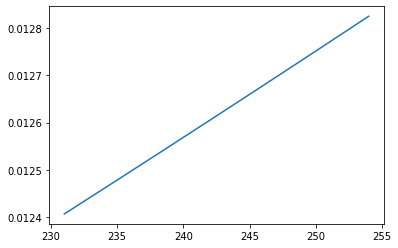

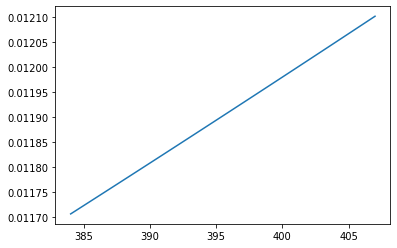

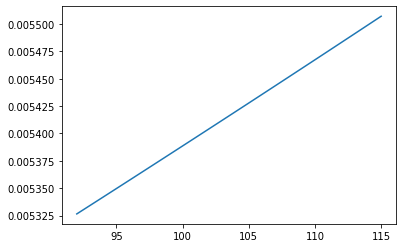

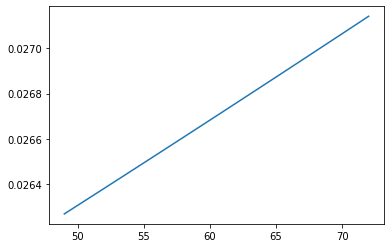

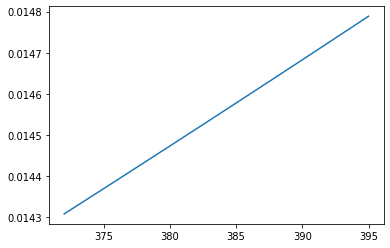

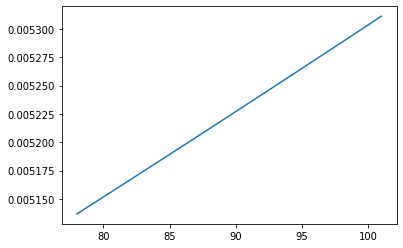

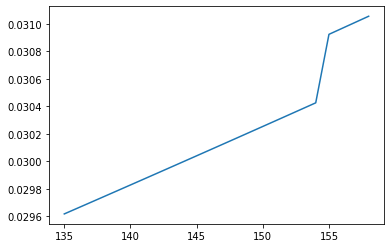

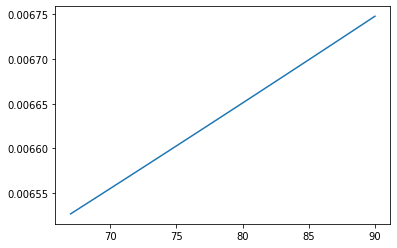

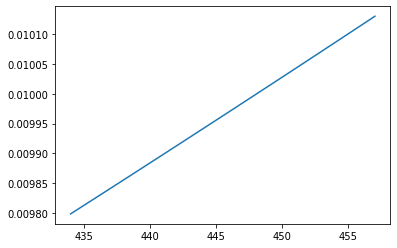

In [191]:
from random import shuffle
list_hosp = patient_notdead_in_hosp['patients']

for a in list_hosp[:10]:
    dt1_sel = dt1[dt1['hadm_id'] == a]
    plt.plot(dt1_sel['t'],dt1_sel['probs'])
    plt.show()

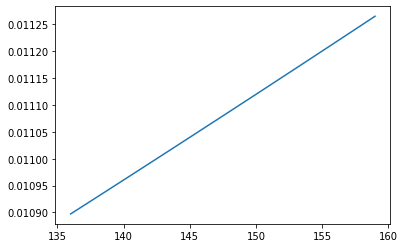

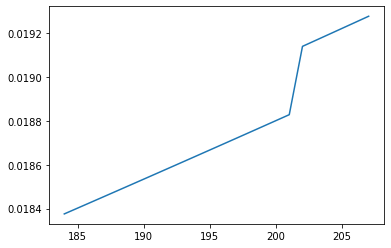

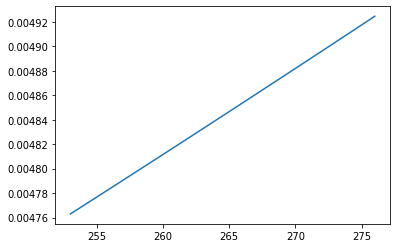

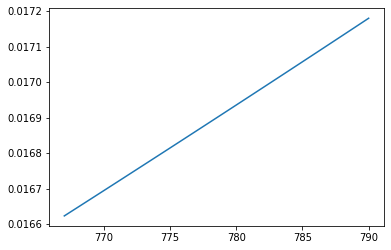

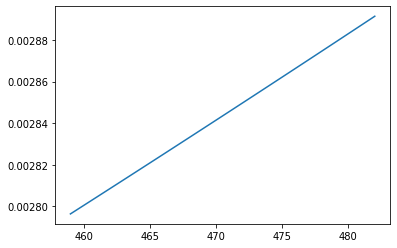

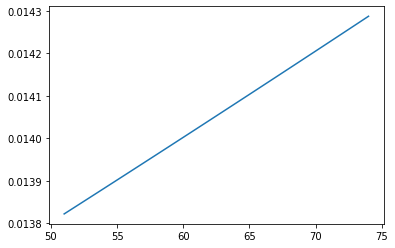

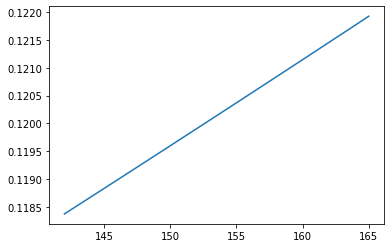

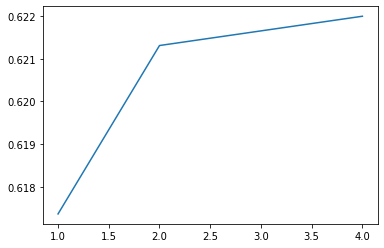

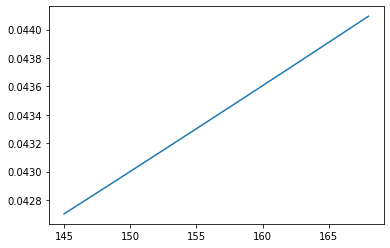

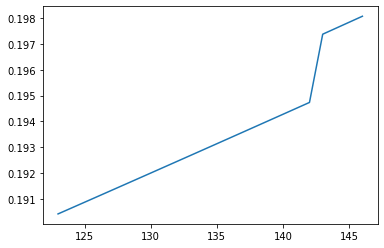

In [192]:

list_hosp = patient_notdead_in_hosp['patients']
random = list_hosp.sample(n =10)
for a in random:
    dt1_sel = dt1[dt1['hadm_id'] == a]
    plt.plot(dt1_sel['t'],dt1_sel['probs'])
    plt.show()